Linear quantile regression

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor

import numpy as np
import cvxpy as cp
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


random_seed = 42

In [2]:
# 1-layer NN
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [3]:
# train mean estimator that estimate E[Y|X]
def mean_est(est_type,X_lin,Y_lin,X_quantile,X_test):
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN1(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_lin))
            labels=Variable(torch.from_numpy(Y_lin))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_quantile = model(torch.from_numpy(X_quantile).float())
        M_quantile = M_quantile.detach().cpu().numpy().reshape(-1,1)
        M_test = model(torch.from_numpy(X_test).float())
        M_test = M_test.detach().cpu().numpy().reshape(-1,1)
        return M_quantile, M_test
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN2(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_lin))
            labels=Variable(torch.from_numpy(Y_lin))
    
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_quantile = model(torch.from_numpy(X_quantile).float())
        M_quantile = M_quantile.detach().cpu().numpy().reshape(-1,1)
        M_test = model(torch.from_numpy(X_test).float())
        M_test = M_test.detach().cpu().numpy().reshape(-1,1)
        return M_quantile, M_test
    if est_type == "rf":
        model = RandomForestRegressor(n_estimators = 500, random_state=random_seed,criterion='squared_error')
        model.fit(X_lin, Y_lin)
        M_quantile = model.predict(X_quantile).reshape(-1,1)
        M_test = model.predict(X_test).reshape(-1,1)
        return M_quantile, M_test
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=random_seed,loss = "squared_error")
        model.fit(X_lin, Y_lin)
        M_quantile = model.predict(X_quantile).reshape(-1,1)
        M_test = model.predict(X_test).reshape(-1,1)
        return M_quantile, M_test

In [4]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t,ylim,legend_loc='upper right'):
    # (X_t,Y_t): test data
    # M_t: mean estimator m(X_t)
    # V_t: variance estimator f(X_t)
    # The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    
    X_sort = np.sort(X_t, axis=0)
    X_sort_indices = np.argsort(X_t, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
    
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
    plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(ylim)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc=legend_loc)
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


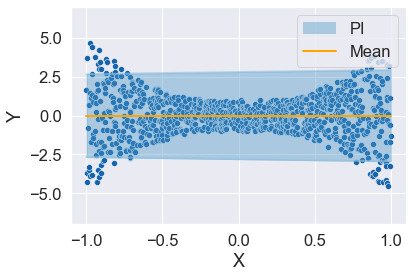

The overall coverage is 0.938
The mean bandwidth for testing data is 7.881222275752785


In [5]:
# Test 1

# Generate i.i.d data
np.random.seed(5)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]


# Estimate the quantile
M_quantile = np.zeros(n_quantile).reshape(-1,1)

alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


M_test = np.zeros(n_test).reshape(-1,1)
V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-7,7])

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


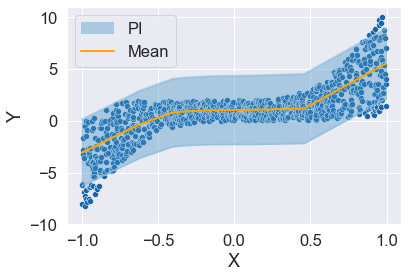

The overall coverage is 0.958
The mean bandwidth for testing data is 10.948582553164007


In [6]:
# Test 2

# Generate i.i.d data
np.random.seed(0)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = 1+5*np.power(X, 3)+np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]


# Estimate the mean using NN2
est_type = "NN2"
M_quantile, M_test = mean_est(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-10,11],legend_loc = 'upper left')


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


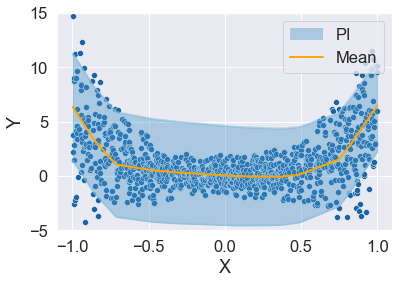

The overall coverage is 0.945
The mean bandwidth for testing data is 20.766783337835783


In [7]:
# Test 3

# Generate i.i.d data (Y follows a constrained Laplace)
np.random.seed(1)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X, 2)+5*np.power(X, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X, 4))

# Specify the bounds for Y
lower_bound = mean_Y - 2 * std_dev_Y
upper_bound = mean_Y + 2 * std_dev_Y

# Generate all Y values initially
Y = np.random.laplace(mean_Y, std_dev_Y)

# Correct values that fall out of bounds
while True:
    out_of_bounds = (Y < lower_bound) | (Y > upper_bound)
    if not np.any(out_of_bounds):
        break
    Y[out_of_bounds] = np.random.laplace(mean_Y[out_of_bounds], std_dev_Y[out_of_bounds])
    

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]

# Estimate the mean using NN2
est_type = "NN2"
M_quantile, M_test = mean_est(est_type,X_lin,Y_lin,X_quantile,X_test)


# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-5,15])



/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


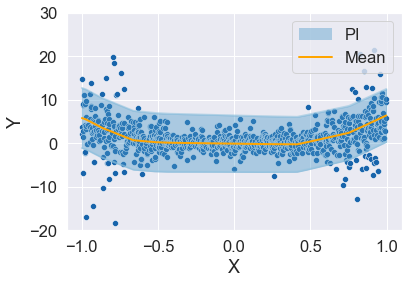

The overall coverage is 0.94
The mean bandwidth for testing data is 41.99683207356734


In [8]:
# Test 4

# Generate i.i.d data (Y follows a constrained Laplace)
np.random.seed(1)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X, 2)+5*np.power(X, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X, 4))

# Generate all Y values
Y = np.random.laplace(mean_Y, std_dev_Y)

    

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]

# Estimate the mean using NN2
est_type = "NN2"
M_quantile, M_test = mean_est(est_type,X_lin,Y_lin,X_quantile,X_test)


# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-20,30])

